In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("raw_data.csv")
series_col = "Close_2330.TW"
exog_cols = [col for col in data.columns if col not in [series_col, "Date"]]
orig_dates = data.index.copy()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data_full = data.reindex(full_index)
price_cols = [c for c in data_full.columns if 'Close' in c]
volume_cols = [c for c in data_full.columns if 'Volume' in c]
return_cols = [c for c in data_full.columns if 'Return' in c]
data_full = data_full.iloc[3:]
# If you want to mark weekends explicitly:
data_full[price_cols] = data_full[price_cols].ffill()
data_full[volume_cols] = data_full[volume_cols].fillna(0)
data_full[return_cols] = data_full[return_cols].fillna(0)
data_full['is_weekend'] = data_full.index.dayofweek >= 5
data = data_full
data = data.sort_index()
y = data[series_col]
x = data[exog_cols]
test_size = 30
y_train = y[:-test_size]
y_test = y[-test_size:]
x_train = x[:-test_size]
x_test = x[-test_size:]

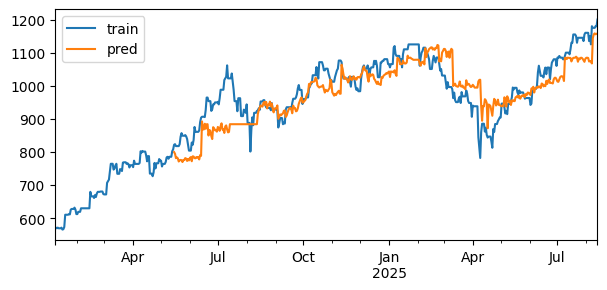

3.432651844349765

In [6]:
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import warnings
from skforecast.exceptions import DataTypeWarning
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from sklearn.linear_model import ElasticNetCV
from catboost import CatBoostRegressor

warnings.simplefilter('ignore', category=DataTypeWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
metrics = [
    # 'mean_absolute_error',
    'root_mean_squared_scaled_error',
    # 'mean_absolute_percentage_error',
    # 'mean_absolute_scaled_error'
]
forecaster = ForecasterRecursive(
                 regressor       = CatBoostRegressor(verbose=0),
                 lags            = 8,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[15]),
                 transformer_y   = PowerTransformer(method="box-cox"))
tscv = TimeSeriesFold(
    steps=30,                 # predict 30 days at a time
    initial_train_size=128,   # start with 1 year of data
    refit=True,
    window_size=10
)
backtest_metrics, predictions = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = y_train,
                                    cv         = tscv,
                                    metric     = metrics,
                                    exog=x_train, 
                                    show_progress=False)
fig, ax = plt.subplots(figsize=(7, 3))
y_train.plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
plt.legend()
plt.show()
backtest_metrics.values.item()

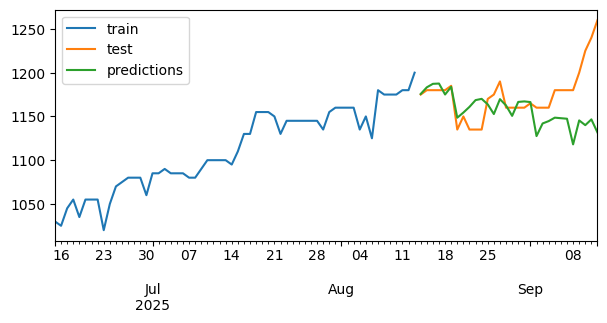

In [8]:
forecaster = ForecasterRecursive(
                 regressor       = CatBoostRegressor(verbose=0),
                 lags            = 8,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[15]),
                 transformer_y   = PowerTransformer(method="box-cox"))
forecaster.fit(y_train, x_train)
predictions = forecaster.predict(steps=len(y_test), exog=x_test)
fig, ax = plt.subplots(figsize=(7, 3))
y_train[-60:].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()